In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import datetime
import requests
import json

import xdmod.datawarehouse as xdw
import xdmod.visualizer as v
import xdmod.outlier_detection as od

from IPython.display import display, Markdown, JSON

In [9]:
# config variables from config.json
with open('config.json', 'r') as f:
    json_variables = json.load(f)

# dictionary mapping hostname -> url
hosts = json_variables['hosts']

# config date objects
today = date.today()
sunday = today - datetime.timedelta(days=1)
last_monday = today - datetime.timedelta(days=7)
last_sunday = last_monday - datetime.timedelta(days=1)
lastlast_monday = last_monday - datetime.timedelta(days=7)

# Alerts 2022-08-18

## metrics-dev

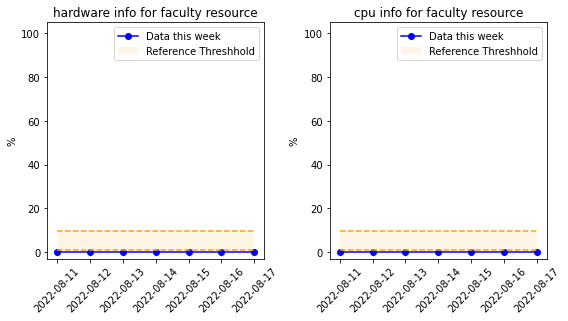

## xdmod-dev

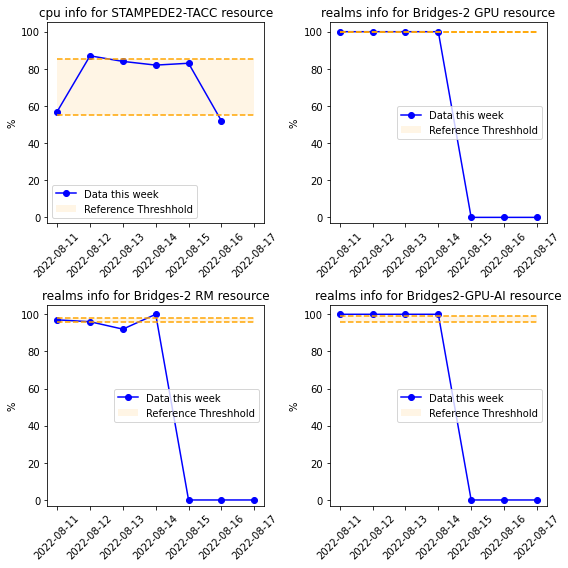

## ookami

<Figure size 576x576 with 0 Axes>

No alerts for this system.

{'metrics-dev': ['Attention needed at: *hardware* query for *faculty* resource', 'Attention needed at: *cpu* query for *faculty* resource'], 'xdmod-dev': ['Attention needed at: *cpu* query for *STAMPEDE2-TACC* resource', 'Attention needed at: *realms* query for *Bridges-2 GPU* resource', 'Attention needed at: *realms* query for *Bridges-2 RM* resource', 'Attention needed at: *realms* query for *Bridges2-GPU-AI* resource']}


In [8]:
display(Markdown(f'# Alerts {today.strftime("%Y-%m-%d")}'))

alert_messages = {}

for host in hosts:
    display(Markdown(f'## {host}'))
    fig = plt.figure(figsize = (8,8))
    subplot_index=1
    with xdw.DataWareHouse(hosts[host]) as warehouse:
        for type in ['gpu', 'hardware', 'cpu', 'script', 'realms']:
            today_data = warehouse.get_qualitydata({"start": last_monday, "end": sunday, "type": type})
            for res in today_data.index:
                outlier_info = od.detect_outlier(today_data, host, res)
                if outlier_info['alert']:
                    res_series = today_data.loc[res]
                    
                    plt.subplot(2,2,subplot_index)
                    subplot_index+=1
                    
                    plt.plot(res_series, 'o-', color = 'b', label = 'Data this week')
                    plt.plot(np.full(len(res_series), outlier_info['ref_mean']),'--', color = 'orange') 
                    plt.fill_between(np.arange(len(res_series)),np.full(len(res_series), outlier_info['ref_mean']), np.full(len(res_series), outlier_info['ref_mean'] - outlier_info['ref_std']), facecolor= 'orange', alpha=.1, label = 'Reference Threshhold')
                    plt.plot(np.full(len(res_series), outlier_info['ref_mean'] - outlier_info['ref_std']),'--', color = 'orange')
                    
                    plt.ylim(-3,105)
                    plt.xticks(rotation=45)
                    
                    plt.ylabel('%')
                    plt.title(f'{type} info for {res} resource')
                    plt.legend()
                    
                    alert_messages[host] = alert_messages.get(host, [])+[f'Attention needed at: *{type}* query for *{res}* resource']    
    
    fig.tight_layout()
    plt.show()
    if len(fig.axes) == 0:
        display(Markdown(f'No alerts for this system.'))
        

# Full Report 2022-08-18

## metrics-dev

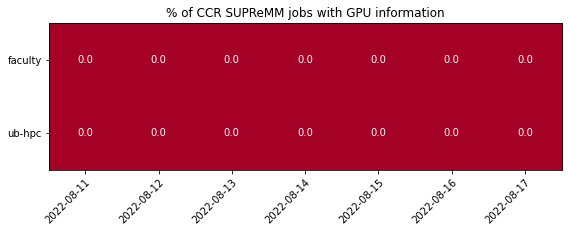

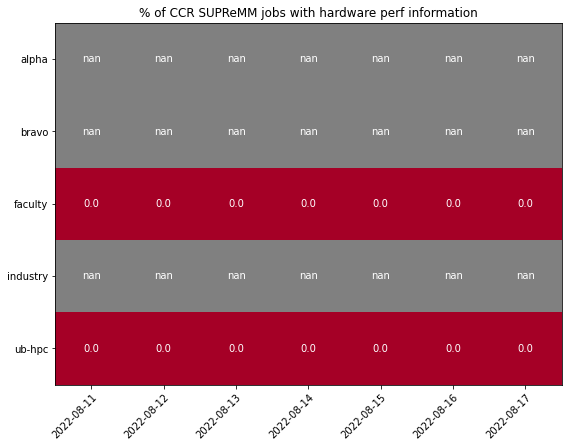

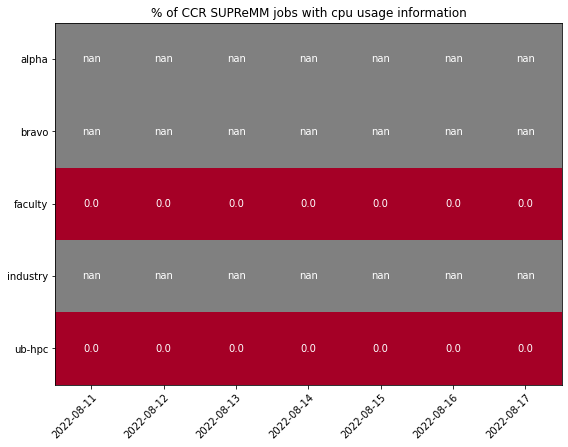

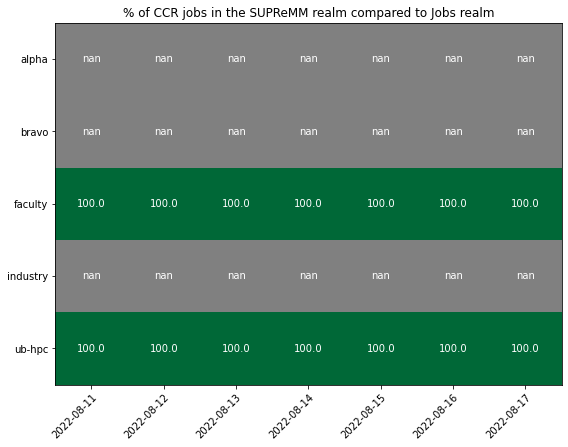

## xdmod-dev

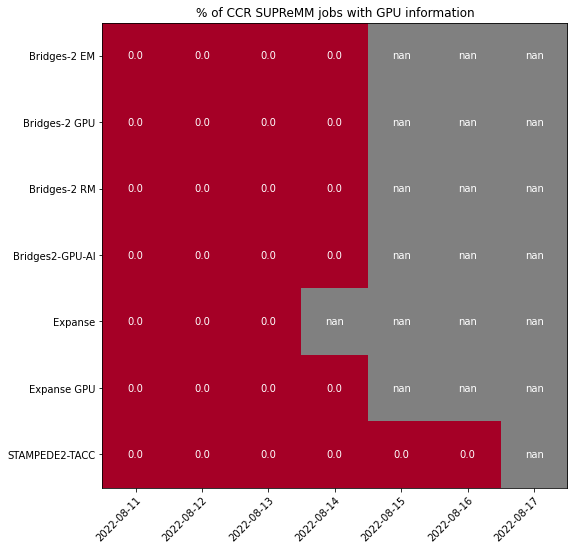

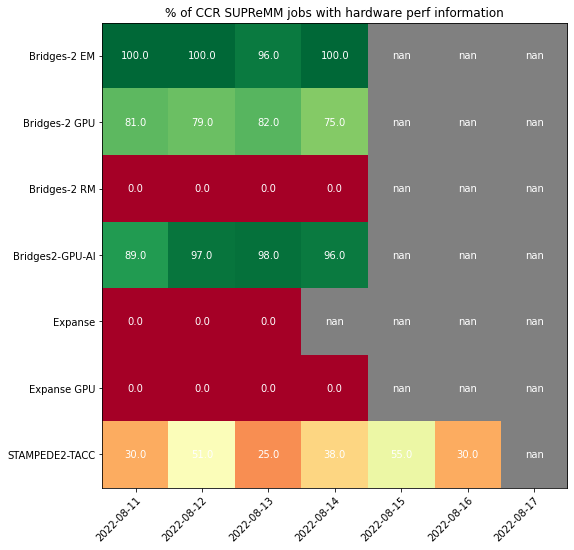

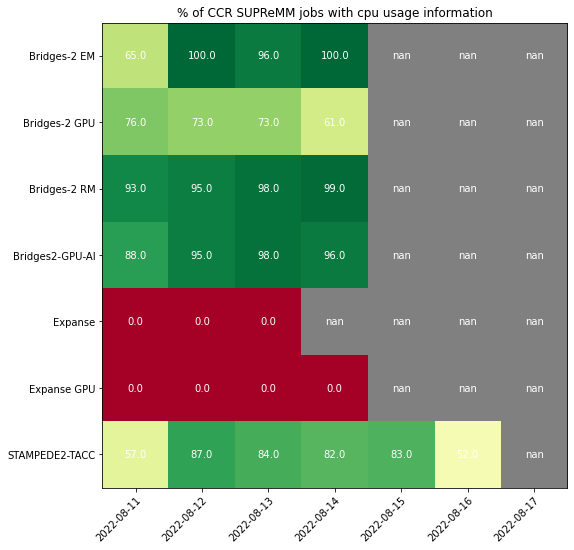

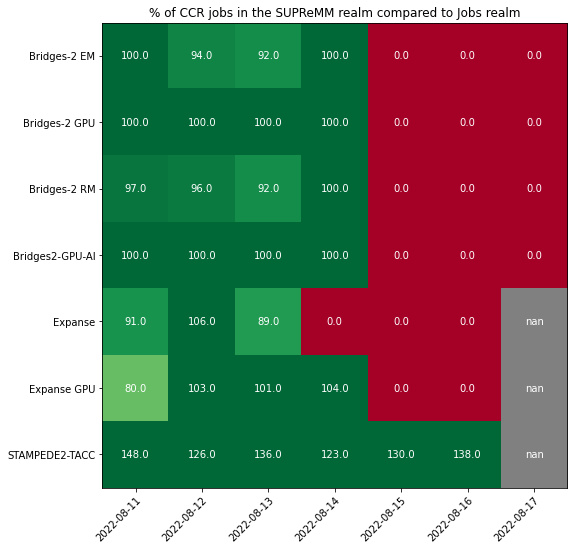

## ookami

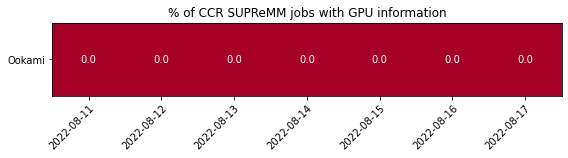

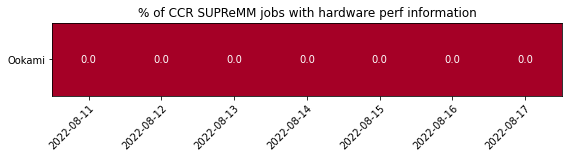

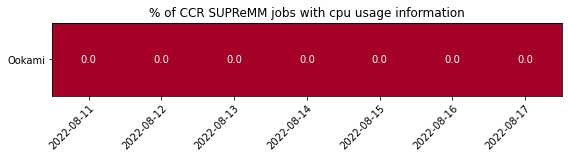

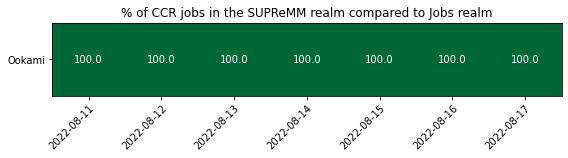

In [5]:
display(Markdown(f'# Full Report {today.strftime("%Y-%m-%d")}'))

for host in hosts:
    display(Markdown(f'## {host}'))
    for type in ['gpu','hardware', 'cpu', 'script','realms']:
        config = {"start": last_monday, "end": sunday, "type": type}
        config_lastweek = {"start": lastlast_monday, "end": last_sunday, "type": type}  
        with xdw.DataWareHouse(hosts[host]) as test:
                data = test.get_qualitydata(config)
                v.quality_heatmap(data)

In [6]:
# alerts setup

# path to report in html format. 
html_path = f'reports/xdmod-alerts/{today.strftime("%Y-%m-%d")}_report.html'

# Slack webhook for post request
# DO NOT EXPOSE ON GITHUB
webhook = json_variables['webhook']

In [10]:
type_to_title = {'gpu': '% of CCR SUPReMM jobs with GPU information', 
                'hardware': '% of CCR SUPReMM jobs with hardware perf information', 
                'cpu': '% of CCR SUPReMM jobs with cpu usage information', 
                'script': '% of CCR SUPReMM jobs with Job Batch Script information', 
                'realms': '% of CCR jobs in the SUPReMM realm compared to Jobs realm'}

payload = {"blocks": [{"type": "section","text": {"type": "mrkdwn","text": f'*SUPReMM Quality Alerts {today}*'}}]}

for host in hosts:
    payload['blocks'].append({"type": "divider"})
    payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": f'*{host}*'}})
    for message in alert_messages.get(host, ["No alerts for this system."]):
        payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": message}})
                    
payload['blocks'].append({"type": "divider"})
payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": f'{hosts["metrics-dev"]}/{html_path}'}})                
                
response = requests.post(webhook, data = json.dumps(payload))